In [1]:
!pip install -U -q opendatasets opencv-python ultralytics

In [2]:
import os
import glob
import random
import yaml

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import opendatasets as od

import torch
assert torch.cuda.is_available(), "CUDA not available"
import ultralytics
from ultralytics import YOLO, settings

In [3]:
import torch

BYTES_IN_GB = 1000_000_000

def print_mem():
    (free, total) = torch.cuda.mem_get_info()
    used = total - free
    
    perc_usaged = round(used / total * 100.0, 1)
    used_gb = round(used / BYTES_IN_GB, 1)
    total_gb = round(total / BYTES_IN_GB, 1)
    print(f'CUDA mem usage: {used_gb}/{total_gb}GB ({perc_usaged}%)')

print_mem()

CUDA mem usage: 0.9/12.5GB (7.6%)


In [4]:
ultralytics.checks()
settings

Ultralytics 8.3.76 🚀 Python-3.11.8 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4070, 11877MiB)
Setup complete ✅ (20 CPUs, 31.1 GB RAM, 453.1/1189.4 GB disk)


{'settings_version': '0.0.6',
 'datasets_dir': '/home/jovyan/notebooks/BrainScan/datasets',
 'weights_dir': 'weights',
 'runs_dir': 'runs',
 'uuid': '188a02b39512c2c610392912d8f3f7376b8d2a0e170c1c9c780bcf8d0fa0651b',
 'sync': True,
 'api_key': '',
 'openai_api_key': '',
 'clearml': True,
 'comet': True,
 'dvc': True,
 'hub': True,
 'mlflow': True,
 'neptune': True,
 'raytune': True,
 'tensorboard': True,
 'wandb': False,
 'vscode_msg': True}

In [5]:
if not os.path.exists("./datasets"):
    od.download('https://www.kaggle.com/datasets/ultralytics/brain-tumor/data')
if os.path.exists("./brain-tumor"):
    os.rename("./brain-tumor", "./datasets")

In [6]:
base_dir = "./datasets"

train_dir = f"{base_dir}/brain-tumor/train"
valid_dir = f"{base_dir}/brain-tumor/valid"
test_dir = f"{base_dir}/brain-tumor/test"

Image `./datasets/brain-tumor/train/images/00074_289.jpg` has shape: (512, 512, 3)
Image `./datasets/brain-tumor/train/images/00176_104.jpg` has shape: (256, 192, 3)
Image `./datasets/brain-tumor/train/images/00104_14.jpg` has shape: (256, 256, 3)


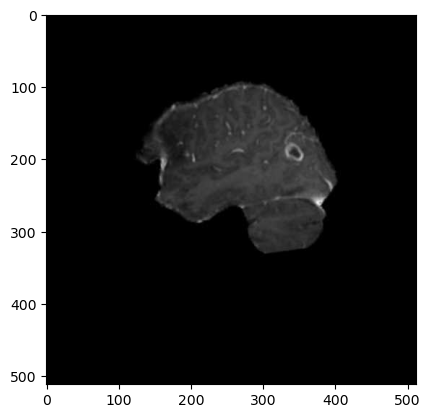

In [7]:
sample_files = glob.glob(train_dir + "/images/*.jpg")
samples = random.sample(sample_files, k=3)

sample_images = []
for sample in samples:
    image = cv2.imread(sample)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sample_images.append(image)
    print(f"Image `{sample}` has shape: {image.shape}")

len(sample_images)

plt.imshow(sample_images[0])

In [8]:
def read_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

def read_labels(label_dir, image_full_path): 
    """
    Output is a list of lists. Where each sublist has 5 float values.
    """

    labels = []
    
    (image_dir, image_path) = os.path.split(image_full_path) 
    (image_name, _ext) = os.path.splitext(image_path)

    label_path = os.path.join(label_dir, image_name + ".txt")
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.read().split("\n")
            labels = [
                [float(value) for value in line.split()] for line in lines
            ]

    return labels

def dir_to_data(directory):
    image_dir = os.path.join(directory, "images")
    label_dir = os.path.join(directory, "labels")

    image_paths = glob.glob(image_dir + "/*.jpg")
    print(f'Total of {len(image_paths)} images found')

    names = []
    images = []
    labels = []
    unlabeled = []
    for image_path in image_paths:
        image = read_image(image_path)
        image_labels = read_labels(label_dir, image_path)

        
        if len(image_labels) > 0:
            for image_label in image_labels:
                names.append(os.path.split(image_path)[-1])
                images.append(image)
                labels.append(image_label)
        else:
            unlabeled.append(image_path)

    print(f'Total of {len(images)} labeled images found (some may contain duplicate labels)')
    print(f'Total of {len(unlabeled)} unlabeled images found')    
    return (names, images, labels, unlabeled)


(names, images, labels, unlabeled) = dir_to_data(train_dir)

assert len(images) == len(labels), "Mismatch in images and labels"

class_mapping = {
    0: 'negative',
    1: 'positive'
}

class_distribution = {'negative': 0, 'positive': 0}
for label in labels:
    cls = class_mapping[int(label[0])]
    class_distribution[cls] +=1

class_distribution

Total of 893 images found
Total of 925 labeled images found (some may contain duplicate labels)
Total of 15 unlabeled images found


{'negative': 437, 'positive': 488}

In [9]:
def split_test_data(force = False):
    if os.path.exists(test_dir) and not force:
        print("Test data was already split")
        return 
        
    os.makedirs(test_dir)
    os.makedirs(test_dir + '/images')
    os.makedirs(test_dir + '/labels')
    
    image_list = glob.glob(valid_dir + "/images/*.jpg")
    label_list = glob.glob(valid_dir + "/labels/*.txt")

    print(f'Total of {len(image_list)}/{len(label_list)} of validation images/labels')

    test_n = int(len(image_list) / 3) # for a 2:1 split between validation and test data
    
    print(f'Moving {test_n}# images/labels from /valid to /test')
    
    test_list = random.sample(image_list, k=test_n)

    for full_image_path in test_list:
        image_path = os.path.split(full_image_path)[-1]
        image_name = os.path.splitext(image_path)[0]
        label_name = image_name + ".txt"
        full_label_path = os.path.join(valid_dir, "labels", label_name)

        if os.path.exists(full_label_path):
            new_image_path = os.path.join(test_dir, "images", image_path)
            new_label_path = os.path.join(test_dir, "labels", label_name)
            
            os.rename(full_image_path, new_image_path)
            os.rename(full_label_path, new_label_path)

    v_i = len(glob.glob(valid_dir + "/images/*.jpg"))
    v_l = len(glob.glob(valid_dir + "/labels/*.txt"))

    t_i = len(glob.glob(test_dir + "/images/*.jpg"))
    t_l = len(glob.glob(test_dir + "/labels/*.txt"))  

    print(f'Total of ({v_i}/{v_l}) , ({t_i}/{t_l}) of validation/test, images/labels')

split_test_data()

Test data was already split


In [10]:
import pandas as pd
df = pd.DataFrame([image.shape for image in images], columns=['w','h','d'])
df.describe()

,w,h,d
count,925.000000,925.000000,925.0
mean,431.809730,417.660541,3.0
std,117.995224,137.699628,0.0
min,256.000000,192.000000,3.0
25%,256.000000,256.000000,3.0
50%,512.000000,512.000000,3.0
75%,512.000000,512.000000,3.0
max,512.000000,512.000000,3.0


In [11]:
def show_images(images, labels):
    fig, axs = plt.subplots(5, 5, figsize=(20, 20))
    axs = axs.flatten()
    
    for i, (name, image, label) in enumerate(zip(names, images, labels)):
        img_height, img_width, _dim = image.shape
        
        lbl_id, lbl_center_x, lbl_center_y, lbl_width, lbl_height = label
        
        x_0 = (lbl_center_x - lbl_width / 2) * img_width
        x_w = img_width * lbl_width
        y_0 = (lbl_center_y - lbl_height / 2) * img_height
        y_w = img_height * lbl_height

        color = ['g', 'r'][int(lbl_id)]
        
        rect = patches.Rectangle((x_0, y_0), x_w, y_w, linewidth=2, edgecolor=color, facecolor='none')

        axs[i].imshow(image)
        axs[i].set_title(name)
        axs[i].add_patch(rect)        
        axs[i].axis("off")

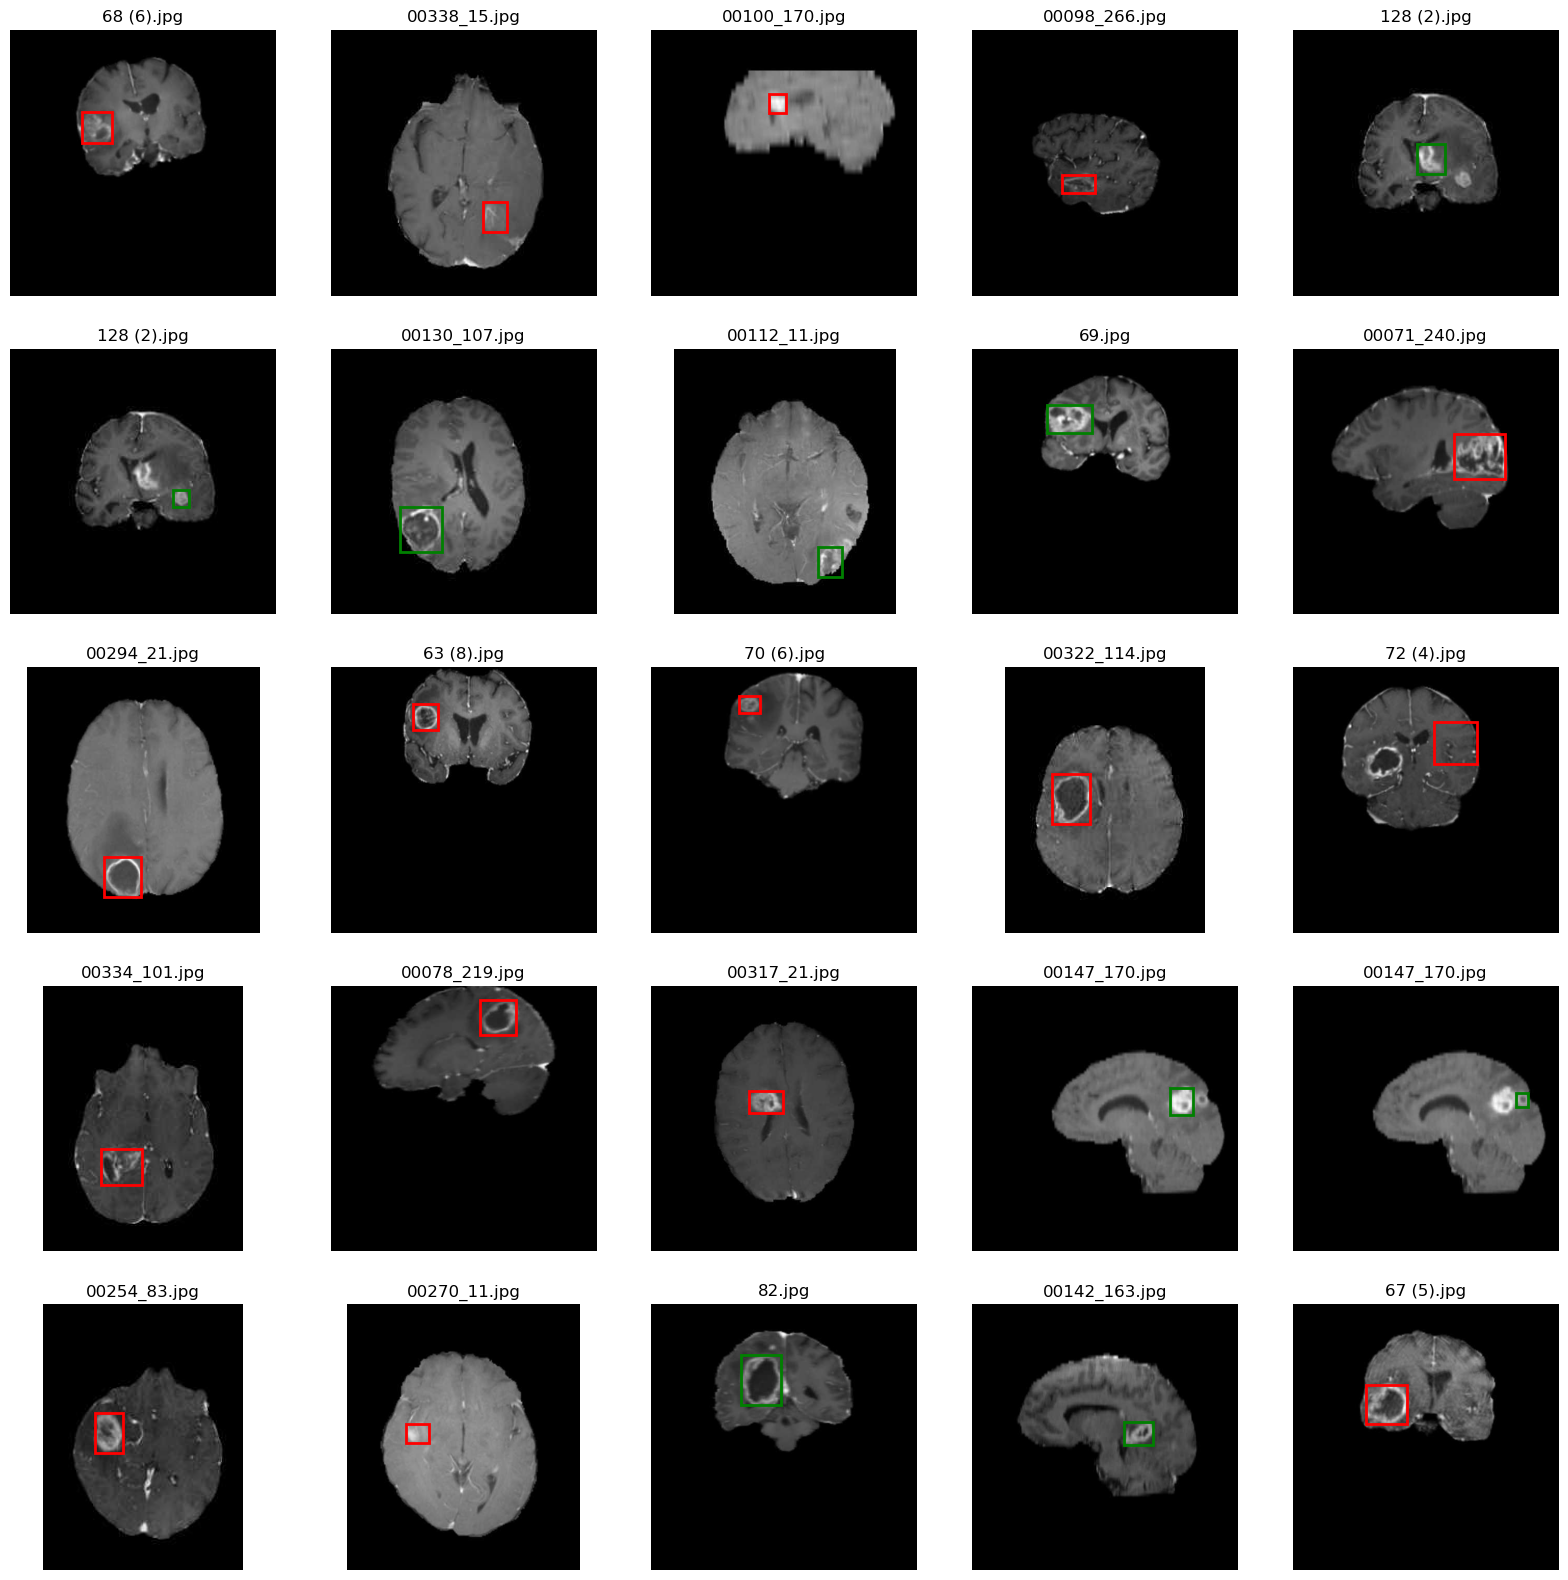

In [12]:
show_images(images[:25], labels[:25])

In [13]:
model = YOLO("yolo11x.pt")
model.to("cuda")

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(384, eps=0.001, momentum=0.03, affine=True, track_

In [14]:
test_images = images[:5]
test_labels = labels[:5]
test_predictions = model.predict(source=test_images, save=True, save_txt=True)


0: 640x640 1 apple, 31.4ms
1: 640x640 (no detections), 31.4ms
2: 640x640 (no detections), 31.4ms
3: 640x640 1 donut, 31.4ms
4: 640x640 1 person, 31.4ms
Speed: 1.6ms preprocess, 31.4ms inference, 12.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict4
3 labels saved to runs/detect/predict4/labels


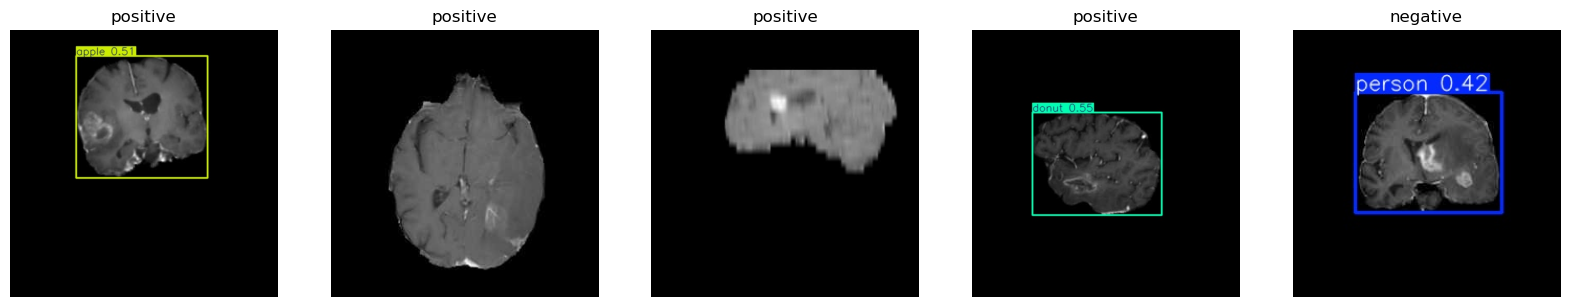

In [15]:
def show_predictions(predictions, true_labels):
    fig, axs = plt.subplots(int(len(predictions) / 5), 5, figsize=(20, 20))
    axs = axs.flatten()

    for i, (prediction, true_label) in enumerate(zip(predictions, true_labels)):
        img_path = os.path.join(prediction.save_dir, prediction.path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

        title = class_mapping[int(true_label[0])]        
        axs[i].imshow(img)
        axs[i].set_title(title)
        axs[i].axis("off")
    
    plt.imshow(img)

show_predictions(test_predictions, test_labels)

In [16]:
train_config_path = os.path.join(base_dir, "data.yaml")
with open(train_config_path, 'w') as f:
    cfg = {
        'path': 'brain-tumor',
        'train': os.path.join("train", "images"),
        'val': os.path.join("valid", "images"),
        'test': os.path.join("test", "images"),
        'names': class_mapping,
        'nc': 2
    }

    yaml.dump(cfg, f)

In [ ]:
print_mem()

metrics = model.train(
    data=train_config_path, 
    imgsz=512,
    # Training params
    epochs=150,
    batch=8,
    patience=30,
    lr0=0.001,
    lrf=0.0001,
    weight_decay=0.0005,
    warmup_epochs=5,
    optimizer='AdamW',
    # Data augmentation
    augment=True,
    mosaic=1.0,
    mixup=0.15,
    degrees=0.3,
    fliplr=0.5,
    flipud=0.25,
    # multi_scale=True
)
print_mem()
metrics.save_dir

CUDA mem usage: 2.6/12.5GB (20.8%)
engine/trainer: task=detect, mode=train, model=yolo11x.pt, data=./datasets/data.yaml, epochs=150, time=None, patience=30, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=F

train: Scanning /home/jovyan/notebooks/BrainScan/datasets/brain-tumor/train/labels.cache... 878 images, 15 backgrounds, 0 corrupt: 
val: Scanning /home/jovyan/notebooks/BrainScan/datasets/brain-tumor/valid/labels.cache... 149 images, 0 backgrounds, 0 corrupt: 100


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs/detect/train5
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      6.01G       1.46      1.916      1.351         13        512: 100%|██████████| 112/112 [00:26<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.2

                   all        149        160      0.468      0.808      0.514       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      6.05G       1.14      1.306      1.106          8        512: 100%|██████████| 112/112 [00:23<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.1

                   all        149        160      0.463      0.834      0.504      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      6.12G      1.127      1.253      1.103         12        512: 100%|██████████| 112/112 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.9

                   all        149        160      0.442      0.831      0.516      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      6.11G      1.089       1.22      1.094         13        512:  80%|████████  | 90/112 [00:18<00:04,  4.81it/s]

In [ ]:
def show_metrics(metrics):
    images = [
        'results.png', 
        'confusion_matrix_normalized.png',
        'F1_curve.png',         
        'P_curve.png',
        'PR_curve.png',
        'R_curve.png'
    ]
    
    fig, axs = plt.subplots(int(len(images) / 2), 2, figsize=(50, 50))
    axs = axs.flatten()

    
    for i, img_path in enumerate(images):
        path = os.path.join(metrics.save_dir, img_path)
        if os.path.exists(path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axs[i].imshow(img)
        axs[i].axis("off")

show_metrics(metrics)

In [ ]:
best_weights = os.path.join(metrics.save_dir, 'weights', 'best.pt')
best_model = YOLO(best_weights, task="detect")
trained_predictions = best_model.predict(source=test_images, save=True)

show_predictions(trained_predictions, test_labels)

In [ ]:
validation_metrics = best_model.val(split='val')
print(validation_metrics.save_dir)
show_metrics(validation_metrics)

# Conslusion
